import packages

In [1]:
import numpy as np
import pandas as pd
import random

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import time

from scipy.stats import gaussian_kde
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingRegressor
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

## 1

In [2]:
bq_data = np.loadtxt('data\BQmat_orig.txt', delimiter=',')

### a

Text(0.5, 0, 'Percent of BQ received')

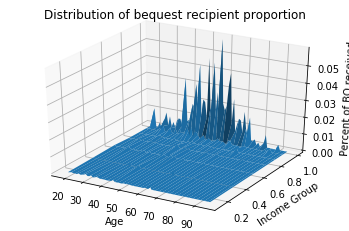

In [3]:
BQ_mat = bq_data / bq_data.sum()

# Make 3D surface plot of rough bequests distribution matrix
age_vec = np.arange(18, 96)
lambdas = np.array([0.25, 0.25, 0.20, 0.10, 0.10, 0.09, 0.01])
lambdas_mdpts = np.array([0.125, 0.375, 0.60, 0.75, 0.85,
                          0.94, 0.995])
income_mat, age_mat = np.meshgrid(lambdas_mdpts, age_vec)
fig = plt.figure()
ax = fig.add_subplot(111, projection ='3d')
ax.plot_surface(age_mat, income_mat, BQ_mat)
ax.set_title('Distribution of bequest recipient proportion')
ax.set_xlabel('Age')
ax.set_ylabel('Income Group')
ax.set_zlabel('Percent of BQ received')

### b

In [4]:
bq_matrix = np.zeros((78*7,3))
for i in range(78):
    bq_matrix[7*i:7*(i+1),0] = i+18
    for j in range(7):
        bq_matrix[7*i+j,1] = j
for k in range(78*7):
    idx1 = int(bq_matrix[k,0]-18)
    idx2 = int(bq_matrix[k,1])
    bq_matrix[k,2] = bq_data[idx1,idx2]
for k in range(1,78*7):
    bq_matrix[k,2] += bq_matrix[k-1,2]
for i in range(78):
    for j in range(7):
        bq_matrix[7*i+j,1] = lambdas_mdpts[j]

In [5]:
def simulation(n):
    Data = np.zeros((n,2))
    for i in range(n):
        num = random.uniform(0,1)
        for k in range(78*7-1):
            if num >= bq_matrix[k,2] and num < bq_matrix[k+1,2]:
                Data[i,0] = bq_matrix[k,0]
                Data[i,1] = bq_matrix[k,1]
                continue
    return Data
Data_sim = simulation(100000)

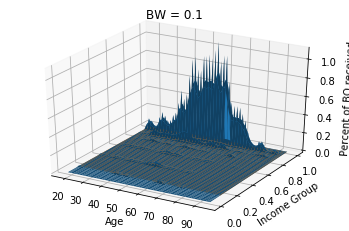

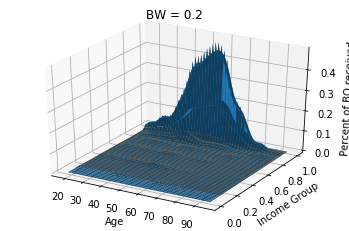

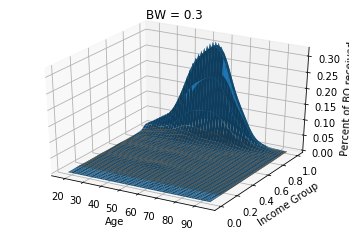

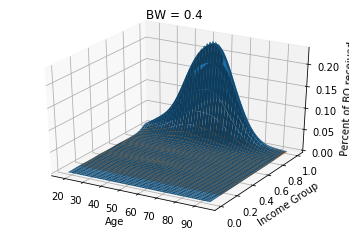

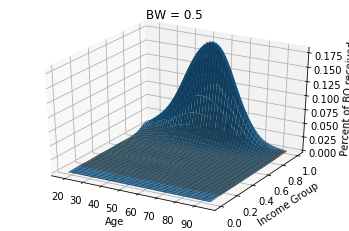

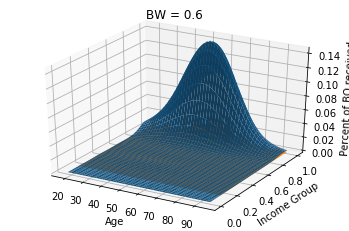

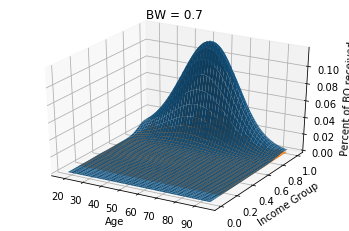

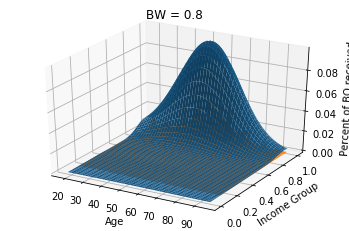

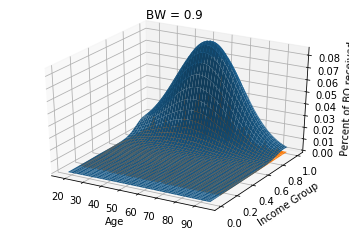

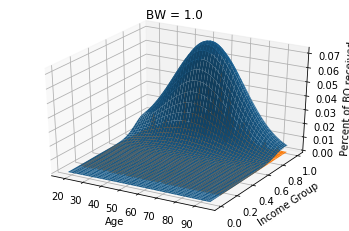

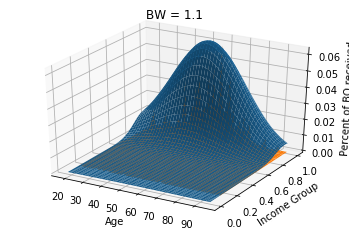

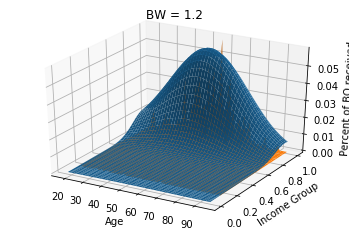

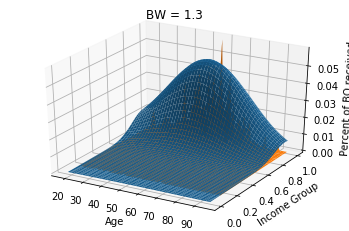

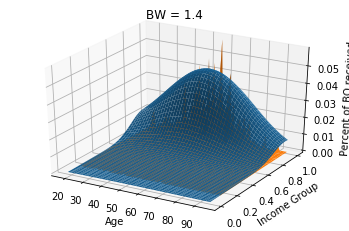

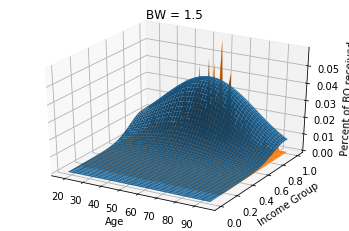

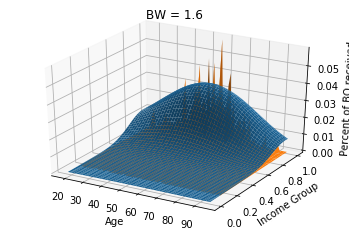

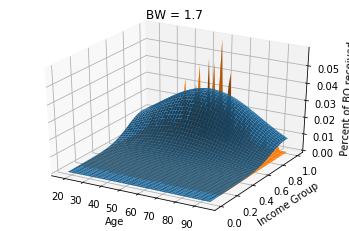

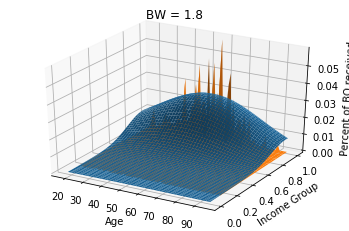

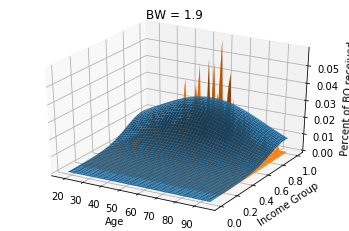

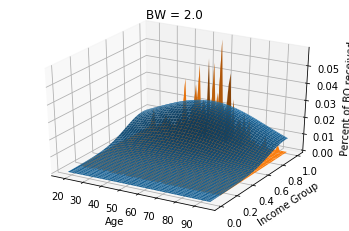

In [6]:
age_min = 18
age_max = 95
income_min = 0
income_max = 1
ages, incomes = np.mgrid[age_min:age_max:100j,
                         income_min:income_max:100j]
bw_best = 0.1
loss_min = np.inf
for i in range(20):
    bw = (i+1)*0.1
    kde = gaussian_kde(Data_sim.T, bw_method = bw)
    coords = np.vstack([item.ravel() for item in [ages, incomes]])
    density = np.reshape(kde(coords), ages.shape)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection ='3d')
    ax.plot_surface(ages, incomes, density)
    ax.plot_surface(age_mat, income_mat, BQ_mat)
    ax.set_title('BW = {:.1f}'.format(bw))
    ax.set_xlabel('Age')
    ax.set_ylabel('Income Group')
    ax.set_zlabel('Percent of BQ received')

Judge from the graphs, bandwidth = 1.2 seems to fit best.

## 2

In [7]:
Auto = pd.read_csv('data/Auto.csv',na_values = "?")
Auto.dropna(inplace=True)
Auto['orgn1'] = 0
Auto.orgn1[Auto['origin']==1] = 1
Auto['orgn2'] = 0
Auto.orgn2[Auto['origin']==2] = 1
Median = Auto['mpg'].median()
Auto['mpg_high'] = 0
Auto.mpg_high[Auto['mpg']>=Median] = 1

### a

In [19]:
y = Auto['mpg_high'].values
X = Auto[['cylinders', 'displacement', 'horsepower', 'weight','acceleration', 'year', 'orgn1', 'orgn2']].values
time_start1 = time.clock()
MSE = []
for i in range(100):
    MSE_part = []
    for j in range(i+1):
        X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.35, random_state=i+j+1)
        LogReg = LogisticRegression()
        LogReg.fit(X_train, y_train)
        y_pred = LogReg.predict(X_test)
        MSE_now = ((y_test - y_pred) ** 2).mean()
        MSE_part.append(MSE_now)
    MSE.append(np.array(MSE_part).mean())
MSE_avg = np.array(MSE).mean()
time_end1 = time.clock()
print('average MSE=', MSE_avg)
print('computation time =',time_end1-time_start1,'seconds')

average MSE= 0.10212295166760964
computation time = 5.637129859999732 seconds


### b

In [20]:
import multiprocessing
from dask import compute, delayed
import dask.multiprocessing

num_cores = multiprocessing.cpu_count()
print('Number of available cores is', num_cores)

def doublecheck(bootstrap, seed, data):
    MSE = []
    for i in range(bootstrap):
        X,y = data
        X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.35, random_state=seed+i)
        LogReg = LogisticRegression()
        LogReg.fit(X_train, y_train)
        y_pred = LogReg.predict(X_test)
        MSE_now = ((y_test - y_pred) ** 2).mean()
        MSE.append(MSE_now)
    return np.array(MSE).mean()
time_start2 = time.clock()
MSE_2 = []
for i in range(100):
    MSE_2.append(delayed(doublecheck)(i+1,i+1,[X,y]))
results_par = compute(*MSE_2, scheduler=dask.multiprocessing.get, num_workers=num_cores)
MSE2_avg = np.array(results_par).mean()
time_end2 = time.clock()
print('average MSE=', MSE2_avg)
print('computation time =',time_end2-time_start2,'seconds')

Number of available cores is 8
average MSE= 0.10212295166760964
computation time = 7.007705700999395 seconds
